In [1]:
# Run this cell to mount your Google Drive.

from IPython.display import clear_output, Image
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [2]:
# !pip install rlcard
!pip install rlcard[torch]
!pip install rlcard[tensorflow]

clear_output()

In [3]:
import torch
import numpy as np
import tensorflow
import os
import importlib

# path
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from MLP import *
from models import *

# remove pycache
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/agents/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/envs/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/games/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/utils/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/
%rm -r __pycache__

%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn

try:
    importlib.reload(rlcard)
    importlib.reload(rlcard.utils)
    importlib.reload(rlcard.agents.random_agent)
    importlib.reload(rlcard.agents.dqn_agent_pytorch)
    importlib.reload(rlcard.agents.simpleGinRummy_agent)
    importlib.reload(rlcard.games.gin_rummy.utils.scorers)
except:
    pass

import rlcard
from rlcard.utils import set_global_seed, tournament, tournament2
from rlcard.utils import Logger
from rlcard.agents.random_agent import RandomAgent
from rlcard.agents.dqn_agent_pytorch import DQNAgent
from rlcard.agents.simpleGinRummy_agent import SimpleGinRummyAgent

# different versions of payoff functions
from rlcard.games.gin_rummy.utils.scorers import *

%cd /content/drive/My Drive/Colab Notebooks/Thesis

/content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning
/content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/agents
rm: cannot remove '__pycache__': No such file or directory
/content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/envs
rm: cannot remove '__pycache__': No such file or directory
/content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/games
rm: cannot remove '__pycache__': No such file or directory
/content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/utils
rm: cannot remove '__pycache__': No such file or directory
/content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard
rm: cannot remove '__pycache__': No such file or directory
/content/drive/My Drive/Colab Notebooks/Thesis/dqn
/content/drive/My Drive/Colab Notebooks/Thesis


# Iterate PT-> Random -> Selfplay -> Random

## 0_random

### Parameters

In [4]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = '0_random'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 20000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 1000

# default: 32
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 100

# Batch Normalization
batch_norm = False

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v4
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
cfg = {'seed': 0}

### Environment Initialization

In [5]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/iterate2/{}'.format(dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                replay_memory_size=replay_memory_size,
                replay_memory_init_size=memory_init_size,       # default: 100
                update_target_estimator_every=update_target_estimator_every,
                discount_factor=0.99,
                epsilon_start=1.0,
                epsilon_end=0.1,
                epsilon_decay_steps=20000,
                batch_size=batch_size,                      # default: 32
                action_num=env.action_num,
                state_shape=env.state_shape,
                train_every=train_every,            # default: 1
                mlp_layers=[520, 520, 110],
                learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                device=device,
                batch_norm=batch_norm)
agent2 = DQNAgent(scope='dqn',
                  replay_memory_size=replay_memory_size,
                  replay_memory_init_size=memory_init_size,       # default: 100
                  update_target_estimator_every=update_target_estimator_every,
                  discount_factor=0.99,
                  epsilon_start=1.0,
                  epsilon_end=0.1,
                  epsilon_decay_steps=20000,
                  batch_size=batch_size,              # default: 32
                  action_num=env.action_num,
                  state_shape=env.state_shape,
                  train_every=train_every,            # default: 1
                  mlp_layers=[520, 520, 110],
                  learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                  device=device,
                  batch_norm=batch_norm)

# Training env
env.set_agents([agent, random_agent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [6]:
model = torch.load('{}'.format(model_name), map_location=device)
model_dict = model.state_dict()
model_dqn_dict = agent.q_estimator.qnet.state_dict()

# Generate pretrained dictionary of weights/biases
pretrained_dict = {}
pretrained_dict['fc_layers.1.weight'] = model_dict['l1.weight']
pretrained_dict['fc_layers.1.bias'] = model_dict['l1.bias']
pretrained_dict['fc_layers.3.weight'] = model_dict['l2.weight']
pretrained_dict['fc_layers.3.bias'] = model_dict['l2.bias']
pretrained_dict['fc_layers.5.weight'] = model_dict['l3.weight']
pretrained_dict['fc_layers.5.bias'] = model_dict['l3.bias']
pretrained_dict['fc_layers.7.weight'] = torch.tensor(np.eye(110), device=device)
pretrained_dict['fc_layers.7.bias'] = torch.tensor(np.ones(110), device=device)

# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)

agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [7]:
# 'freezing weights'
agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
agent.q_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
agent.q_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
agent.target_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
agent.target_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

agent2.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent2.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent2.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent2.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
agent2.q_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
agent2.q_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

agent2.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
agent2.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
agent2.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
agent2.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
agent2.target_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
agent2.target_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

### Train

#### Training Loop

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/iterate2/{}'.format(dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        reward_rand = tournament(random_env, evaluate_num)[0]
        actions_rand = tournament2(random_env, evaluate_num)
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        reward_self = tournament(selfplay_env, evaluate_num)[0]
        actions_self = tournament2(selfplay_env, evaluate_num)
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        reward_sgr = tournament(SGRAgent_env, evaluate_num)[0]
        actions_sgr = tournament2(SGRAgent_env, evaluate_num)
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

#### Training Plots

In [22]:
model_name = 'models/dqn/iterate2/0_random/model_posttrain.pth'

In [23]:
checkpoint = torch.load(model_name, map_location=device)

In [24]:
agent.load(checkpoint)
agent2.load(checkpoint)

###### Random

In [25]:
tournament2(random_env, evaluate_num)

{'Avg Turns': 68.55, 'Gin': 27, 'Knock': 5, 'Knock_Possible': 426, 'Other': 68}

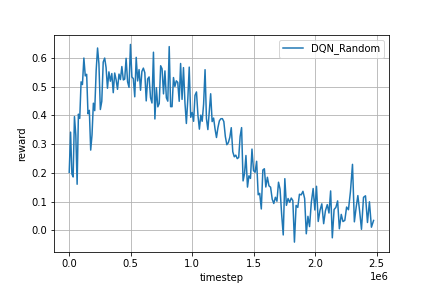

In [17]:
Image(log_dir + '/rand_fig.png')

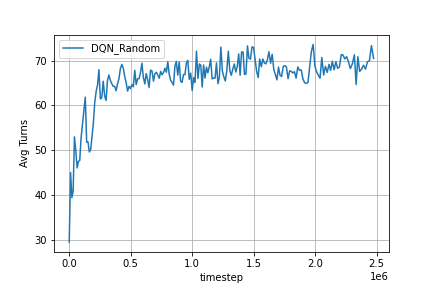

In [18]:
Image(log_dir + '/rand_fig2.png')

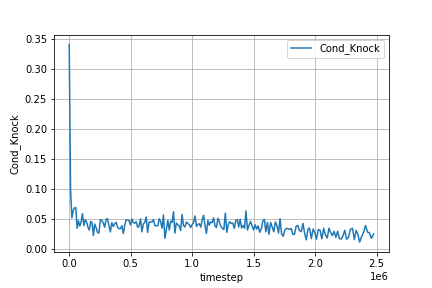

In [19]:
Image(log_dir + '/rand_fig3.png')

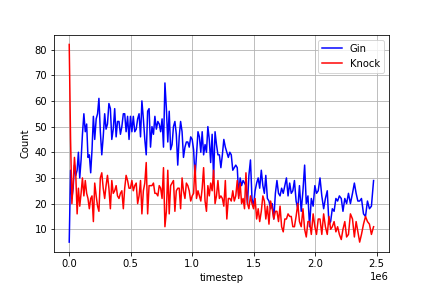

In [20]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [26]:
tournament2(selfplay_env, evaluate_num)


Total Number Resets: 11


{'Avg Turns': 64.96,
 'Gin': 22,
 'Knock': 15,
 'Knock_Possible': 349,
 'Other': 63}

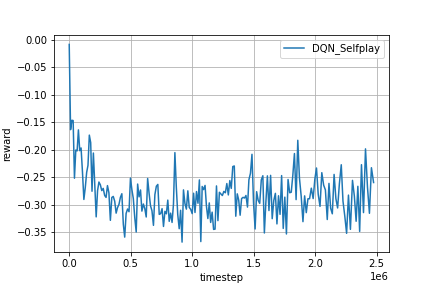

In [27]:
Image(log_dir + '/self_fig.png')

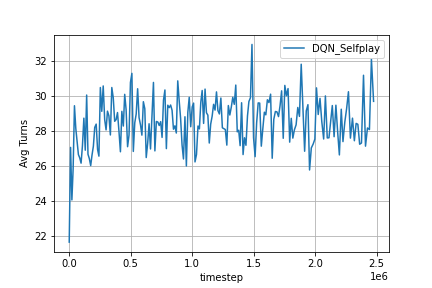

In [28]:
Image(log_dir + '/self_fig2.png')

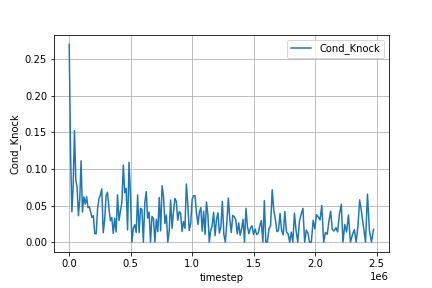

In [29]:
Image(log_dir + '/self_fig3.png')

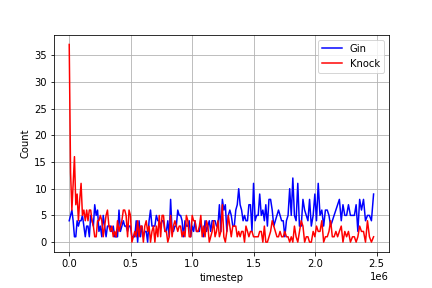

In [30]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [31]:
tournament2(SGRAgent_env, evaluate_num)

{'Avg Turns': 17.7, 'Gin': 2, 'Knock': 0, 'Knock_Possible': 34, 'Other': 98}

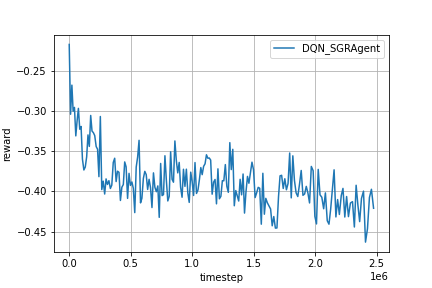

In [32]:
Image(log_dir + '/sgr_fig.png')

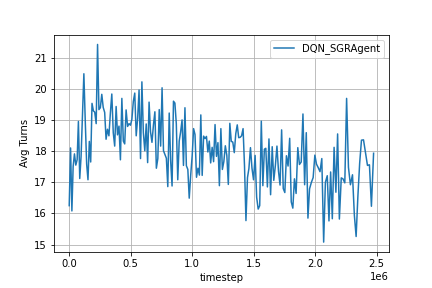

In [33]:
Image(log_dir + '/sgr_fig2.png')

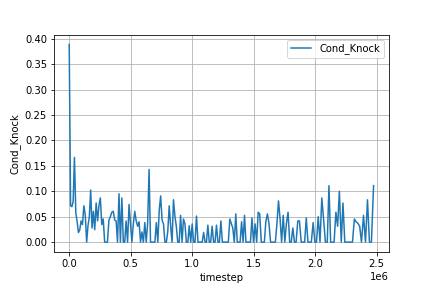

In [34]:
Image(log_dir + '/sgr_fig3.png')

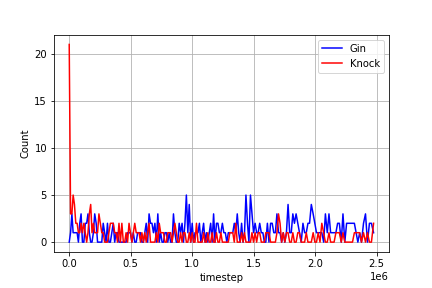

In [35]:
Image(log_dir + '/sgr_fig4.png')

## 1_selfplay

### Parameters

In [ ]:
# Pretrain model selection
# model_name = 'models/dqn/iterate2/0_random/model_posttrain.pth'
model_name = 'models/dqn/iterate2/0_random/model_rand.pth'
dqn_model_name = '1_selfplay'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 20000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 1000

# default: 32
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 100

# Batch Normalization
batch_norm = False

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v4
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/iterate2/{}'.format(dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                replay_memory_size=replay_memory_size,
                replay_memory_init_size=memory_init_size,       # default: 100
                update_target_estimator_every=update_target_estimator_every,
                discount_factor=0.99,
                epsilon_start=1.0,
                epsilon_end=0.1,
                epsilon_decay_steps=20000,
                batch_size=batch_size,                      # default: 32
                action_num=env.action_num,
                state_shape=env.state_shape,
                train_every=train_every,            # default: 1
                mlp_layers=[520, 520, 110],
                learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                device=device,
                batch_norm=batch_norm)
agent2 = DQNAgent(scope='dqn',
                  replay_memory_size=replay_memory_size,
                  replay_memory_init_size=memory_init_size,       # default: 100
                  update_target_estimator_every=update_target_estimator_every,
                  discount_factor=0.99,
                  epsilon_start=1.0,
                  epsilon_end=0.1,
                  epsilon_decay_steps=20000,
                  batch_size=batch_size,              # default: 32
                  action_num=env.action_num,
                  state_shape=env.state_shape,
                  train_every=train_every,            # default: 1
                  mlp_layers=[520, 520, 110],
                  learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                  device=device,
                  batch_norm=batch_norm)

# Training env
env.set_agents([agent, agent2])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)
agent2.load(checkpoint)

### Train

#### Training Loop

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/iterate2/{}'.format(dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        reward_rand = tournament(random_env, evaluate_num)[0]
        actions_rand = tournament2(random_env, evaluate_num)
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        reward_self = tournament(selfplay_env, evaluate_num)[0]
        actions_self = tournament2(selfplay_env, evaluate_num)
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        reward_sgr = tournament(SGRAgent_env, evaluate_num)[0]
        actions_sgr = tournament2(SGRAgent_env, evaluate_num)
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

Streaming output truncated to the last 5000 lines.

Total Number Resets: 3

Total Number Resets: 24

Total Number Resets: 33

Total Number Resets: 3

Total Number Resets: 5

Total Number Resets: 93

Total Number Resets: 147

Total Number Resets: 7

Total Number Resets: 17

Total Number Resets: 95

Total Number Resets: 56

Total Number Resets: 58

Total Number Resets: 28

Total Number Resets: 39

Total Number Resets: 40

Total Number Resets: 45

Total Number Resets: 31

Total Number Resets: 126

Total Number Resets: 9

Total Number Resets: 24

Total Number Resets: 20

Total Number Resets: 14

Total Number Resets: 19

Total Number Resets: 10

Total Number Resets: 77

Total Number Resets: 85

Total Number Resets: 8

Total Number Resets: 36

Total Number Resets: 9

Total Number Resets: 31

Total Number Resets: 3

Total Number Resets: 5

Total Number Resets: 59

Total Number Resets: 78

Total Number Resets: 43

Total Number Resets: 29

Total Number Resets: 41

Total Number Resets: 42

Total

#### Training Plots

###### Random

In [ ]:
tournament2(random_env, evaluate_num)

In [ ]:
Image(log_dir + '/rand_fig.png')

In [ ]:
Image(log_dir + '/rand_fig2.png')

In [ ]:
Image(log_dir + '/rand_fig3.png')

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
tournament2(selfplay_env, evaluate_num)

In [ ]:
Image(log_dir + '/self_fig.png')

In [ ]:
Image(log_dir + '/self_fig2.png')

In [ ]:
Image(log_dir + '/self_fig3.png')

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
tournament2(SGRAgent_env, evaluate_num)

In [ ]:
Image(log_dir + '/sgr_fig.png')

In [ ]:
Image(log_dir + '/sgr_fig2.png')

In [ ]:
Image(log_dir + '/sgr_fig3.png')

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## 2_random

### Parameters

In [ ]:
# Pretrain model selection
model_name = 'models/dqn/iterate2/1_selfplay/model_posttrain.pth'
dqn_model_name = '2_random'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 20000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 1000

# default: 32
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 100

# Batch Normalization
batch_norm = False

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v4
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/iterate/{}'.format(dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                replay_memory_size=replay_memory_size,
                replay_memory_init_size=memory_init_size,       # default: 100
                update_target_estimator_every=update_target_estimator_every,
                discount_factor=0.99,
                epsilon_start=1.0,
                epsilon_end=0.1,
                epsilon_decay_steps=20000,
                batch_size=batch_size,                      # default: 32
                action_num=env.action_num,
                state_shape=env.state_shape,
                train_every=train_every,            # default: 1
                mlp_layers=[520, 520, 110],
                learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                device=device,
                batch_norm=batch_norm)
agent2 = DQNAgent(scope='dqn',
                  replay_memory_size=replay_memory_size,
                  replay_memory_init_size=memory_init_size,       # default: 100
                  update_target_estimator_every=update_target_estimator_every,
                  discount_factor=0.99,
                  epsilon_start=1.0,
                  epsilon_end=0.1,
                  epsilon_decay_steps=20000,
                  batch_size=batch_size,              # default: 32
                  action_num=env.action_num,
                  state_shape=env.state_shape,
                  train_every=train_every,            # default: 1
                  mlp_layers=[520, 520, 110],
                  learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                  device=device,
                  batch_norm=batch_norm)

# Training env
env.set_agents([agent, random_agent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)
agent2.load(checkpoint)

In [ ]:
# model = torch.load('{}'.format(model_name), map_location=device)
# model_dict = model.state_dict()
# model_dqn_dict = agent.q_estimator.qnet.state_dict()

# # Generate pretrained dictionary of weights/biases
# pretrained_dict = {}
# pretrained_dict['fc_layers.1.weight'] = model_dict['l1.weight']
# pretrained_dict['fc_layers.1.bias'] = model_dict['l1.bias']
# pretrained_dict['fc_layers.3.weight'] = model_dict['l2.weight']
# pretrained_dict['fc_layers.3.bias'] = model_dict['l2.bias']
# pretrained_dict['fc_layers.5.weight'] = model_dict['l3.weight']
# pretrained_dict['fc_layers.5.bias'] = model_dict['l3.bias']
# pretrained_dict['fc_layers.7.weight'] = torch.tensor(np.eye(110), device=device)
# pretrained_dict['fc_layers.7.bias'] = torch.tensor(np.ones(110), device=device)
# # pretrained_dict['fc_layers.7.bias'] = agent.target_estimator.qnet.fc_layers[7].bias

# # load pretrained weights
# agent.q_estimator.qnet.load_state_dict(pretrained_dict)
# agent.target_estimator.qnet.load_state_dict(pretrained_dict)

# agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
# agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

In [ ]:
# # 'freezing weights'
# agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
# agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
# agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
# agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
# agent.q_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
# agent.q_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

# agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
# agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
# agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
# agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
# agent.target_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
# agent.target_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

# agent2.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
# agent2.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
# agent2.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
# agent2.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
# agent2.q_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
# agent2.q_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

# agent2.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
# agent2.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
# agent2.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
# agent2.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
# agent2.target_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
# agent2.target_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

### Train

#### Training Loop

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/iterate2/{}'.format(dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        reward_rand = tournament(random_env, evaluate_num)[0]
        actions_rand = tournament2(random_env, evaluate_num)
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        reward_self = tournament(selfplay_env, evaluate_num)[0]
        actions_self = tournament2(selfplay_env, evaluate_num)
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        reward_sgr = tournament(SGRAgent_env, evaluate_num)[0]
        actions_sgr = tournament2(SGRAgent_env, evaluate_num)
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

#### Training Plots

###### Random

In [ ]:
tournament2(random_env, evaluate_num)

In [ ]:
Image(log_dir + '/rand_fig.png')

In [ ]:
Image(log_dir + '/rand_fig2.png')

In [ ]:
Image(log_dir + '/rand_fig3.png')

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
tournament2(selfplay_env, evaluate_num)

In [ ]:
Image(log_dir + '/self_fig.png')

In [ ]:
Image(log_dir + '/self_fig2.png')

In [ ]:
Image(log_dir + '/self_fig3.png')

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
tournament2(SGRAgent_env, evaluate_num)

In [ ]:
Image(log_dir + '/sgr_fig.png')

In [ ]:
Image(log_dir + '/sgr_fig2.png')

In [ ]:
Image(log_dir + '/sgr_fig3.png')

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## 3_selfplay

### Parameters

In [ ]:
# Pretrain model selection
model_name = 'models/dqn/iterate2/2_random/model_posttrain.pth'
dqn_model_name = '3_selfplay'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 20000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 1000

# default: 32
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 100

# Batch Normalization
batch_norm = False

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v4
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/iterate/{}'.format(dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                replay_memory_size=replay_memory_size,
                replay_memory_init_size=memory_init_size,       # default: 100
                update_target_estimator_every=update_target_estimator_every,
                discount_factor=0.99,
                epsilon_start=1.0,
                epsilon_end=0.1,
                epsilon_decay_steps=20000,
                batch_size=batch_size,                      # default: 32
                action_num=env.action_num,
                state_shape=env.state_shape,
                train_every=train_every,            # default: 1
                mlp_layers=[520, 520, 110],
                learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                device=device,
                batch_norm=batch_norm)
agent2 = DQNAgent(scope='dqn',
                  replay_memory_size=replay_memory_size,
                  replay_memory_init_size=memory_init_size,       # default: 100
                  update_target_estimator_every=update_target_estimator_every,
                  discount_factor=0.99,
                  epsilon_start=1.0,
                  epsilon_end=0.1,
                  epsilon_decay_steps=20000,
                  batch_size=batch_size,              # default: 32
                  action_num=env.action_num,
                  state_shape=env.state_shape,
                  train_every=train_every,            # default: 1
                  mlp_layers=[520, 520, 110],
                  learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                  device=device,
                  batch_norm=batch_norm)

# Training env
env.set_agents([agent, agent2])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

### Load Pretrained Weights

Apply pretrained weights to the correct layers

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)
agent2.load(checkpoint)

In [ ]:
# model = torch.load('{}'.format(model_name), map_location=device)
# model_dict = model.state_dict()
# model_dqn_dict = agent.q_estimator.qnet.state_dict()

# # Generate pretrained dictionary of weights/biases
# pretrained_dict = {}
# pretrained_dict['fc_layers.1.weight'] = model_dict['l1.weight']
# pretrained_dict['fc_layers.1.bias'] = model_dict['l1.bias']
# pretrained_dict['fc_layers.3.weight'] = model_dict['l2.weight']
# pretrained_dict['fc_layers.3.bias'] = model_dict['l2.bias']
# pretrained_dict['fc_layers.5.weight'] = model_dict['l3.weight']
# pretrained_dict['fc_layers.5.bias'] = model_dict['l3.bias']
# pretrained_dict['fc_layers.7.weight'] = torch.tensor(np.eye(110), device=device)
# pretrained_dict['fc_layers.7.bias'] = torch.tensor(np.ones(110), device=device)
# # pretrained_dict['fc_layers.7.bias'] = agent.target_estimator.qnet.fc_layers[7].bias

# # load pretrained weights
# agent.q_estimator.qnet.load_state_dict(pretrained_dict)
# agent.target_estimator.qnet.load_state_dict(pretrained_dict)

# agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
# agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

In [ ]:
# # 'freezing weights'
# agent.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
# agent.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
# agent.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
# agent.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
# agent.q_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
# agent.q_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

# agent.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
# agent.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
# agent.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
# agent.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
# agent.target_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
# agent.target_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

# agent2.q_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
# agent2.q_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
# agent2.q_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
# agent2.q_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
# agent2.q_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
# agent2.q_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

# agent2.target_estimator.qnet.fc_layers[1].weight = torch.nn.Parameter(model.l1.weight)
# agent2.target_estimator.qnet.fc_layers[1].bias = torch.nn.Parameter(model.l1.bias)
# agent2.target_estimator.qnet.fc_layers[3].weight = torch.nn.Parameter(model.l2.weight)
# agent2.target_estimator.qnet.fc_layers[3].bias = torch.nn.Parameter(model.l2.bias)
# agent2.target_estimator.qnet.fc_layers[5].weight = torch.nn.Parameter(model.l3.weight)
# agent2.target_estimator.qnet.fc_layers[5].bias = torch.nn.Parameter(model.l3.bias)

### Train

#### Training Loop

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/iterate2/{}'.format(dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        reward_rand = tournament(random_env, evaluate_num)[0]
        actions_rand = tournament2(random_env, evaluate_num)
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        reward_self = tournament(selfplay_env, evaluate_num)[0]
        actions_self = tournament2(selfplay_env, evaluate_num)
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        reward_sgr = tournament(SGRAgent_env, evaluate_num)[0]
        actions_sgr = tournament2(SGRAgent_env, evaluate_num)
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

#### Training Plots

###### Random

In [ ]:
tournament2(random_env, evaluate_num)

In [ ]:
Image(log_dir + '/rand_fig.png')

In [ ]:
Image(log_dir + '/rand_fig2.png')

In [ ]:
Image(log_dir + '/rand_fig3.png')

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
tournament2(selfplay_env, evaluate_num)

In [ ]:
Image(log_dir + '/self_fig.png')

In [ ]:
Image(log_dir + '/self_fig2.png')

In [ ]:
Image(log_dir + '/self_fig3.png')

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
tournament2(SGRAgent_env, evaluate_num)

In [ ]:
Image(log_dir + '/sgr_fig.png')

In [ ]:
Image(log_dir + '/sgr_fig2.png')

In [ ]:
Image(log_dir + '/sgr_fig3.png')

In [ ]:
Image(log_dir + '/sgr_fig4.png')

# Misc

In [ ]:
model_name = 'models/dqn/iterate2/0_random/model_rand.pth'

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)
agent2.load(checkpoint)

./plots/dqn/iterate2/0_random/sgr_performance.csv
./plots/dqn/iterate2/0_random/sgr_performance.csv
./plots/dqn/iterate2/0_random/sgr_performance.csv
./plots/dqn/iterate2/0_random/sgr_performance.csv


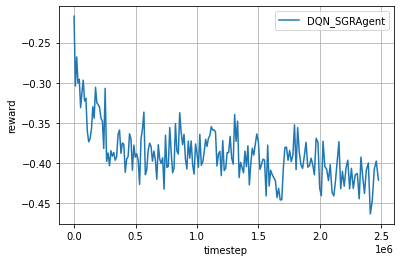

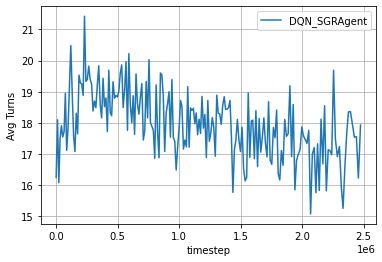

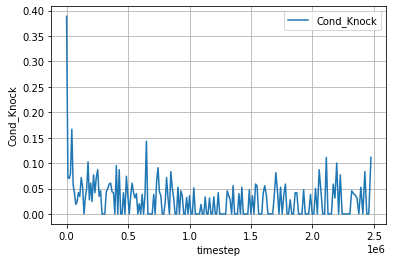

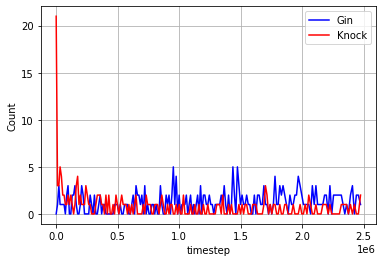

In [ ]:
from rlcard.utils.logger import plot, plot_condknock,plot_actions
import os

# env_name = 'rand_'
# env_name = 'self_'
env_name = 'sgr_'
# algorithm = 'DQN_Random'
# algorithm = 'DQN_Selfplay'
algorithm = 'DQN_SGRAgent'
csv_path = os.path.join(log_dir, env_name + 'performance.csv') 
fig_path = os.path.join(log_dir, env_name + 'fig.png')
fig_path2 = os.path.join(log_dir, env_name + 'fig2.png')
fig_path3 = os.path.join(log_dir, env_name + 'fig3.png')
fig_path4 = os.path.join(log_dir, env_name + 'fig4.png')

plot(csv_path, fig_path, algorithm, ylabel='reward')
plot(csv_path, fig_path2, algorithm, ylabel='Avg Turns')
plot_condknock(csv_path, fig_path3)
plot_actions(csv_path, fig_path4)